# 03 | Tweets analysis


## PREPARE THE TWEETS

### Preprocessing functions (Twitter specific)

Separate in 'tokens', translate special characters and special expressions (emoticons), remove stopwords. Below are some basic preprocessing functions:

In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join

import json, re, operator, string, nltk
from nltk.tokenize import word_tokenize

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs

    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def tokenize(s):
    return tokens_re.findall(s)

def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

### Loading the tweets > SCRAPING

Downloading all tweets from a list of users; storing userID, text, timestamp

The first analysis on the text is made using the tweet text, which has been imported from the eight .csv files collected with the scraping script.

In [28]:
# load .csv files created by SCRAPING
files = [f for f in listdir('Twitter_SCRAPING/scraped/') if f.endswith('.csv') and isfile(join('Twitter_SCRAPING/scraped/', f))]
d_scrape = pd.concat([pd.read_csv('Twitter_SCRAPING/scraped/'+f, encoding='utf-8') for f in files], keys=files)
print(d_scrape.head())

                                          id           created_at  \
iperezarnal_tweets.csv 0  926568933259382784  2017-11-03 21:57:03   
                       1  926380962979737605  2017-11-03 09:30:07   
                       2  926376863160729602  2017-11-03 09:13:50   
                       3  926347531746992129  2017-11-03 07:17:16   
                       4  926207577008103424  2017-11-02 22:01:09   

                                                                       text  
iperezarnal_tweets.csv 0  b'Tenemos 42 nuevos seguidores, desde Alemania...  
                       1  b'Blockchain Investment Trends In Review https...  
                       2  b'RT @BIMCommunity: La necesidad de monitoriza...  
                       3  b'#HomoDigitalis: Wie die Digitalisierung Freu...  
                       4  b'RT @AsidekAutodesk: Generar renderizaciones ...  


Peprocess the tweet text and create a string of tweet words to analyse for word frequency and keywords.

In [29]:
# convert the text column from the dataframe to a string
tweets_l_scrape = d_scrape['text'].tolist() # create a list from 'text' column in d dataframe
print(tweets_l_scrape[-1:])

["b'Google developing SDK to make Android the standard for\\xa0wearables http://t.co/QriQSrwbgY via @VentureBeat #android #wearables'"]


### Loading the tweets > STREAMING: PROFILES

Prograsivelly stream all tweets from a list of users; gathers all available data and metadata into a .json file

The second, or parallel analysis is made on the text of tweets which are imported from a collection of tweets from profiles. 

In [2]:
# load .json files created by STREAMING
#files = [f for f in listdir('Twitter_SCRAPING/profile/') if f.endswith('.json') and isfile(join('Twitter_SCRAPING/profile/', f))]
#d_stream_profiles = pd.concat([pd.read_json('Twitter_SCRAPING/profile'+f, lines=True) for f in files], keys=files)
d_stream_profiles = pd.read_json('Twitter_SCRAPING/profile_tweets.json', lines=True)
# convert the text column from the dataframe to a string
tweets_l_stream_profiles = d_stream_profiles['text'].tolist() # create a list from 'text' column in d dataframe
print(tweets_l_stream_profiles[-1:])

['@markasaurus @eparillon I have 2 out of 3 now!']


### Loading the tweets > STREAMING: KEYWORDS

Prograsivelly stream all tweets from a list of users; gathers all available data and metadata into a .json file

The second, or parallel analysis is made on the text of tweets which are imported from a collection of tweets from profiles. 

In [8]:
# load .json files created by STREAMING
#files = [f for f in listdir('Twitter_SCRAPING/') if f.endswith('.json') and isfile(join('Twitter_SCRAPING/', f))]
#d_stream = pd.concat([pd.read_json(f, lines=True) for f in files], keys=files)
d_stream_keywords = pd.read_json('Twitter_SCRAPING/keyword_tweets.json', lines=True)
# convert the text column from the dataframe to a string
tweets_l_stream_keywords = d_stream_keywords['text'].tolist() # create a list from 'text' column in d dataframe
print(tweets_l_stream_keywords[-1:])

['#Ascurra #AvBrasilia #SantaCatarina #IoT #SSP #Comunidade https://t.co/Ru05nqG3Mc']


## 1) Word Frequencies and Wordclouds

Import the necessary libraries and lists of stopwords.

In [3]:
from nltk.corpus import stopwords
from collections import Counter, defaultdict
from itertools import chain
from nltk.probability import FreqDist
from nltk import bigrams 

import numpy as np
import matplotlib.pyplot as plt

#stopwords
with open("Twitter_MINING/twitter-sentiment-analysis-stopwords.txt", 'rb') as f:
    twitterstop = [str(word.strip(), 'utf-8') for word in f.readlines()]
stop = stopwords.words('english') + list(string.punctuation) + twitterstop

In [4]:
# Frequency function
def count_freq(tweet_list):
    corpus = []
    text_terms = [term for term in preprocess(' '.join(map(str, tweet_list)))]
    all_tokens = [x.lower() for x in text_terms]
    # Count All Tokens
    tokens_number = len(all_tokens)
    corpus.append(('total tokens', tokens_number)) # update corpus comparison
    print('Total number of words in the collection: ', tokens_number)
    # remove stop words
    words = [term for term in all_tokens if term not in stop and not term.startswith('http') and len(term)>2]
    corpus.append(('meaningful words', len(words))) # update corpus comparison
    print('Total number of meaningful words (without stopwords and links): ', len(words))
    # LEMMATIZATION (Optional)
    #porter = nltk.PorterStemmer()
    #words_stemmed = [porter.stem(term) for term in words]
    #print('Total number of meaningful words, stemmed: ', len(words_scrape_stemmed))
    # Count terms only once, equivalent to Document Frequency
    unique_words = set(words)
    corpus.append(('unique words', len(unique_words))) # update corpus comparison
    print('Number of unique terms: ', len(unique_words))
    return words, corpus

### Word Frequency > SCRAPING

Prepare a list of all words in tweets (including mentions, hashtags, links, excluding stop words). This is going to be amore concentrated, less diverse discourse, as the selection is of 8 profiles only and they were a preselected group that determined keywords to listen to. 

In [ ]:
words_scrape, corups_tweets_scraped = count_freq(tweets_l_scrape)
wordfreq = FreqDist(words_scrape)
print('The 100 most frequent terms, including special terms: ', wordfreq.most_common(100))

In [8]:
# Count terms only (no hashtags, no mentions)
words_only_scrape = [term for term in words_scrape if not term.startswith('#') and not term.startswith('@')]
print('The number of words only (no hashtags, no mentions): ', len(words_only_scrape))

The number of words only (no hashtags, no mentions):  15375181


In [9]:
# Word frequency for terms only (no hashtags, no mentions)
words_only_scrape_freq = FreqDist(words_only_scrape)
print('The 20 most frequent terms (terms only): ', words_only_scrape_freq.most_common(20))

The 20 most frequent terms (terms only):  [('bim', 93889), ('design', 71353), ('time', 48625), ('thanks', 47271), ('big', 45457), ('great', 45058), ('project', 44306), ('architecture', 42038), ('one', 41889), ('like', 41429), ('today', 40879), ('archispeak', 39864), ('see', 37158), ('future', 36998), ('day', 36648), ('data', 35350), ('good', 33026), ('work', 32827), ('building', 32782), ('podcast', 32468)]


In [12]:
# Count hashtags only

words_hash_scrape = [term for term in words_scrape if term.startswith('#')]
corpus_tweets_scraped.append(('hashtags', len(words_hash_scrape))) # update corpus comparison
print('Total number of hashtags: ', len(words_hash_scrape)) #, set(terms_hash_stream))

Total number of words in the collection:  45029942
Total number of meaningful words (without stopwords and links):  20695119
Number of unique terms:  33169
[('total tokens', 45029942), ('meaningful words', 20695119), ('unique words', 33169)]


In [15]:
# Count mentions only
words_mention_scrape = [term for term in words_scrape if term.startswith('@')]
corpus_tweets_scraped.append(('mentions', len(words_mention_scrape))) # update corpus comparison
print('Total number of mentions: ', len(words_mention_scrape)) #, set(terms_mention_stream))

Total number of mentions:  2983700


In [16]:
# Mentions and Hashtags frequency
mentionsfreq = FreqDist(words_mention_scrape)
print("20 most common mentions: ", mentionsfreq.most_common(20))
hashfreq = FreqDist(words_hash_scrape)
print("20 most common hashtags: ", hashfreq.most_common(20))

20 most common mentions:  [('@bjarkeingels', 194941), ('@case_inc', 82347), ('@dynamobim', 65243), ('@archispk', 62263), ('@archinate', 58684), ('@provinggroundio', 46266), ('@brianringley', 37765), ('@bimcommunity', 36996), ('@bimsummit', 35787), ('@npann', 32767), ('@archy_type', 28841), ('@bigstertweets', 27362), ('@ikeough', 26276), ('@zachkron', 23863), ('@randydeutsch', 22821), ('@andrewheumann', 20843), ('@etroxel', 19532), ('@entrearchitect', 19177), ('@iperezarnal', 17215), ('@serpentineuk', 16761)]
20 most common hashtags:  [('#bim', 161037), ('#architecture', 56337), ('#design', 47153), ('#gh3d', 47035), ('#3dprint', 34683), ('#computation', 30690), ('#dynamo', 23256), ('#revit', 22964), ('#data', 19076), ('#synbio', 17568), ('#omaha', 15912), ('#construction', 15856), ('#robots', 13592), ('#nexthuman', 13137), ('#nextcolony', 12986), ('#robot', 12788), ('#dynamobim', 12383), ('#nextdesign', 12080), ('#arehacks', 11627), ('#ai', 11023)]


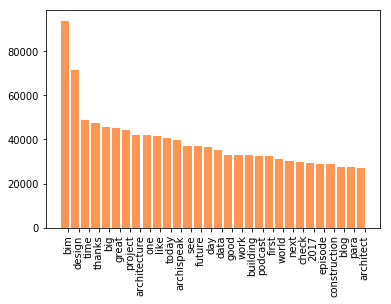

In [193]:
popularwords = words_only_scrape_freq.most_common(30)

labels, values = zip(*popularwords)
#print(labels, values)
# sort your values in descending order
indSort = np.argsort(values)[::-1]
# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]
indexes = np.arange(len(labels))
bar_width = 0.35
plt.bar(indexes, values, color='#FF9653')
# add labels
plt.xticks(indexes + bar_width, labels, rotation='vertical')
plt.show()

### Word Frequency > STREAMING: PROFILES

Prepare a list of all words in tweets (including mentions, hashtags, links, excluding stop words)

In [10]:
words_sp, corpus_tweets_streamed_profile = count_freq(tweets_l_stream_profiles)
words_sp_freq = FreqDist(words_sp)
print('The 100 most frequent terms, including special terms: ', words_sp_freq.most_common(100))

Total number of words in the collection:  232685
Total number of meaningful words (without stopwords and links):  109123
Number of unique terms:  16716
The 100 most frequent terms, including special terms:  [('#bim', 1254), ('@autodesk', 927), ('@algoritmic', 708), ('bim', 690), ('@theb1m', 667), ('#construction', 631), ('#revit', 530), ('@markasaurus', 520), ('design', 469), ('building', 380), ('@randydeutsch', 372), ('help', 339), ('@autodeskrevit', 335), ('@autodeskhelp', 326), ('see', 315), ('video', 296), ('2017', 294), ('@bentleysystems', 291), ('one', 289), ('using', 286), ('make', 283), ('great', 269), ('people', 262), ('autodesk', 257), ('@autocad', 254), ('autocad', 250), ('@elrondburrell', 230), ('thanks', 224), ('like', 224), ('@thespacesmag', 224), ('time', 218), ('learn', 217), ('#aec', 215), ('work', 212), ('project', 211), ('construction', 210), ('revit', 210), ('field', 207), ('world', 205), ('@bimchannel', 204), ('look', 203), ('know', 200), ('future', 193), ('@bimsum

In [8]:
# Count terms only (no hashtags, no mentions)
words_only_sp = [term for term in words_sp if not term.startswith('#') and not term.startswith('@')]
corpus_tweets_streamed_profile.append(('words', len(words_only_sp))) # update corpus comparison
print('The number of words only (no hashtags, no mentions): ', len(words_only_sp))

The number of words only (no hashtags, no mentions):  82662


In [9]:
# Word frequency for terms only (no hashtags, no mentions)
words_only_sp_freq = FreqDist(words_only_sp)
print('The 100 most frequent terms (terms only): ', words_only_sp_freq.most_common(20))

The 100 most frequent terms (terms only):  [('bim', 690), ('design', 469), ('building', 380), ('help', 339), ('see', 315), ('video', 296), ('2017', 294), ('one', 289), ('using', 286), ('make', 283), ('great', 269), ('people', 262), ('autodesk', 257), ('autocad', 250), ('thanks', 224), ('like', 224), ('time', 218), ('learn', 217), ('work', 212), ('project', 211)]


In [10]:
# Count hashtags only
words_hash_sp = [term for term in words_sp if term.startswith('#')]
corpus_tweets_streamed_profile.append(('hashtags', len(words_hash_sp))) # update corpus comparison
print('List and total number of hashtags: ', len(words_hash_sp)) #, set(terms_hash_stream))

List and total number of hashtags:  9275


In [11]:
# Count mentions only
words_mention_sp = [term for term in words_sp if term.startswith('@')]
corpus_tweets_streamed_profile.append(('mentions', len(words_mention_sp))) # update corpus comparison
print('List and total number of mentions: ', len(set(words_mention_sp))) #, set(terms_mention_stream))

List and total number of mentions:  3138


In [12]:
# Mentions and Hashtags frequency
mentionsfreq = FreqDist(words_mention_sp)
print("20 most common mentions: ", mentionsfreq.most_common(20))
hashfreq = FreqDist(words_hash_sp)
print("20 most common hashtags: ", hashfreq.most_common(20))

20 most common mentions:  [('@autodesk', 927), ('@algoritmic', 708), ('@theb1m', 667), ('@markasaurus', 520), ('@randydeutsch', 372), ('@autodeskrevit', 335), ('@autodeskhelp', 326), ('@bentleysystems', 291), ('@autocad', 254), ('@elrondburrell', 230), ('@thespacesmag', 224), ('@bimchannel', 204), ('@bimsummit', 190), ('@bimireland', 188), ('@autodesku', 180), ('@aewarchitects', 158), ('@qbimgest', 113), ('@crassociati', 110), ('@pbc_today', 108), ('@lynn_allen', 93)]
20 most common hashtags:  [('#bim', 1254), ('#construction', 631), ('#revit', 530), ('#aec', 215), ('#passivhaus', 168), ('#architecture', 143), ('#design', 105), ('#machinelearning', 100), ('#autocad35', 98), ('#architects', 97), ('#vr', 95), ('#math', 91), ('#tbt', 90), ('#au2017', 84), ('#bimsummit', 79), ('#autocad', 68), ('#mediasummit2017', 66), ('#bsibcn2017', 54), ('#parametric', 52), ('#mathgifs', 52)]


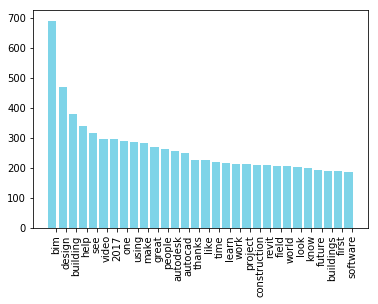

In [194]:
import numpy as np
import matplotlib.pyplot as plt

popularwords = words_only_sp_freq.most_common(30)

labels, values = zip(*popularwords)
#print(labels, values)
# sort your values in descending order
indSort = np.argsort(values)[::-1]
# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]
indexes = np.arange(len(labels))
bar_width = 0.35
plt.bar(indexes, values, color='#7ED4E8')
# add labels
plt.xticks(indexes + bar_width, labels, rotation='vertical')
plt.show()

### Word Frequency > STREAMING: KEYWORDS

Prepare a list of all words in tweets (including mentions, hashtags, links, excluding stop words)

In [123]:
words_sk, corups_tweets_streamed_keywords = count_freq(tweets_l_stream_keywords, corpus_tweets_streamed_keywords)
wordfreq = FreqDist(words_sk)
print('The 100 most frequent terms, including special terms: ', wordfreq.most_common(100))

['#infosec', '…', 'https://t.co/dppkjdv5zw', '#ascurra', '#avbrasilia', '#santacatarina', '#iot', '#ssp', '#comunidade', 'https://t.co/ru05nqg3mc']


In [124]:
#Count All Tokens
total_tokens_sk = len(all_tokens_sk)
corpus_tweets_streamed_keyword.append(('total tokens', total_tokens_sk)) # update corpus comparison
print('Total number of words (including mentions, hashtags and links) in the collection: ', total_tokens_sk)

Total number of words (including mentions, hashtags and links) in the collection:  236140


In [125]:
# remove stop and other words, links
words_sk = [term for term in all_tokens_sk if term not in stop and not term.startswith('http') and len(term)>2]
corpus_tweets_streamed_keyword.append(('meaningful words', len(words_sk))) # update corpus comparison
print('Total number of meaningful words (without stopwords and links): ', len(words_sk))

Total number of meaningful words (without stopwords and links):  129812


In [126]:
# Count terms only once, equivalent to Document Frequency
unique_words_sk = set(words_sk)
corpus_tweets_streamed_keyword.append(('unique words', len(unique_words_sk))) # update corpus comparison
print('Number of unique terms: ', len(unique_words_sk))

Number of unique terms:  17972


In [127]:
#Word frequency for all terms (including hashtags and mentions)
wordfreq = FreqDist(words_sk)
print('The 100 most frequent terms, including special terms: ', wordfreq.most_common(100))

The 100 most frequent terms, including special terms:  [('#iot', 5317), ('network', 3460), ('#artificialintelligence', 2413), ('#ai', 2217), ('#internetofthings', 2102), ('#iiot', 1974), ('#watson', 1710), ('#cognitive', 1699), ('#bigdata', 1644), ('#blockchain', 1344), ('#ssp', 1227), ('#comunidade', 1227), ('#ibm', 1086), ('#industrialiot', 808), ('iot', 808), ('#technology', 721), ('#business', 687), ('bully', 630), ('engagement', 617), ('#machinelearning', 590), ('ibm', 589), ('@iotrecruiting', 554), ('supply', 523), ('pay', 520), ('chain', 519), ('demo', 508), ('store', 506), ('#dl', 472), ('#ml', 469), ('#internetofthing', 436), ('digital', 421), ('data', 400), ('#tech', 390), ('@ai_iot_iiot_ioe', 389), ('commerce', 386), ('sensor', 370), ('#cybersecurity', 368), ('news', 341), ('@socialmedia_ist', 339), ('@smdominator', 330), ('#cloud', 320), ('internet', 319), ('business', 312), ('big', 297), ('@up2gu', 297), ('คนท', 297), ('มารวมต', 297), ('นเยอะมาก', 297), ('จนกลายเป', 297), 

In [129]:
# Count terms only (no hashtags, no mentions)
words_only_sk = [term for term in words_sk if not term.startswith('#') and not term.startswith('@')]
corpus_tweets_streamed_keyword.append(('words', len(words_only_sk))) # update corpus comparison
print('The number of words only (no hashtags, no mentions): ', len(words_only_sk))

The number of words only (no hashtags, no mentions):  74049


In [131]:
# Word frequency for terms only (no hashtags, no mentions)
words_only_sk_freq = FreqDist(words_only_sk)
print('The 100 most frequent terms (terms only): ', words_only_sk_freq.most_common(30))

The 100 most frequent terms (terms only):  [('network', 3460), ('iot', 808), ('bully', 630), ('engagement', 617), ('ibm', 589), ('supply', 523), ('pay', 520), ('chain', 519), ('demo', 508), ('store', 506), ('digital', 421), ('data', 400), ('commerce', 386), ('sensor', 370), ('news', 341), ('internet', 319), ('business', 312), ('big', 297), ('คนท', 297), ('มารวมต', 297), ('นเยอะมาก', 297), ('จนกลายเป', 297), ('งหว', 297), ('rum', 297), ('social', 269), ('manager', 265), ('insights', 255), ('transvoyant', 250), ('power', 244), ('market', 241)]


In [132]:
# Count hashtags only
words_hash_sk = [term for term in words_sk if term.startswith('#')]
corpus_tweets_streamed_keyword.append(('hashtags', len(words_hash_sk))) # update corpus comparison
print('List and total number of hashtags: ', len(words_hash_sk)) #, set(terms_hash_stream))

List and total number of hashtags:  44576


In [133]:
# Count mentions only
words_mention_sk = [term for term in words_sk if term.startswith('@')]
corpus_tweets_streamed_keyword.append(('mentions', len(words_mention_sk))) # update corpus comparison
print('List and total number of mentions: ', len(set(words_mention_sk))) #, set(terms_mention_stream))

List and total number of mentions:  3114


In [134]:
# Mentions and Hashtags frequency
mentionsfreq = FreqDist(words_mention_sk)
print("20 most common mentions: ", mentionsfreq.most_common(20))
hashfreq = FreqDist(words_hash_sk)
print("20 most common hashtags: ", hashfreq.most_common(20))

20 most common mentions:  [('@iotrecruiting', 554), ('@ai_iot_iiot_ioe', 389), ('@socialmedia_ist', 339), ('@smdominator', 330), ('@up2gu', 297), ('@rajneeshchhabra', 228), ('@sachinlulla', 220), ('@2018socialmedia', 214), ('@delizalde', 206), ('@digital_mummy', 180), ('@akanshadigital', 169), ('@sunnyraydigital', 150), ('@manjeetrege', 118), ('@vertiai', 114), ('@yarmolukdan', 112), ('@mvasey', 109), ('@dollyraydigital', 104), ('@urbanmediallc', 99), ('@dollyray1987', 99), ('@sudhirchaudhary', 92)]
20 most common hashtags:  [('#iot', 5317), ('#artificialintelligence', 2413), ('#ai', 2217), ('#internetofthings', 2102), ('#iiot', 1974), ('#watson', 1710), ('#cognitive', 1699), ('#bigdata', 1644), ('#blockchain', 1344), ('#ssp', 1227), ('#comunidade', 1227), ('#ibm', 1086), ('#industrialiot', 808), ('#technology', 721), ('#business', 687), ('#machinelearning', 590), ('#dl', 472), ('#ml', 469), ('#internetofthing', 436), ('#tech', 390)]


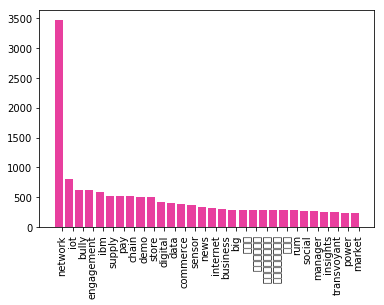

In [195]:
import numpy as np
import matplotlib.pyplot as plt

popularwords = words_only_sk_freq.most_common(30)

labels, values = zip(*popularwords)
#print(labels, values)
# sort your values in descending order
indSort = np.argsort(values)[::-1]
# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]
indexes = np.arange(len(labels))
bar_width = 0.35
plt.bar(indexes, values, color='#E83F9E')
# add labels
plt.xticks(indexes + bar_width, labels, rotation='vertical')
plt.show()

## Writing things down

Finally, for the purpose of future research, we want to write certain information to a file: word frequency for each corpus, as well as lists and frequences for sets of hasthags and mentions.

In [172]:
import pickle

# word frequencies
with open('wordfrequency_scrape.txt', 'wb') as f:
    pickle.dump(words_only_scrape_freq.most_common(), f)
    
with open('wordfrequency_stream_profiles.txt', 'wb') as f:
    pickle.dump(words_only_sp_freq.most_common(), f)

with open('wordfrequency_stream_keywords.txt', 'wb') as f:
    pickle.dump(words_only_sk_freq.most_common(), f)

# hashtags
with open('hashtags_scrape.txt', 'wb') as f:
    pickle.dump(FreqDist(words_hash_scrape).most_common(), f)
    
with open('hashtags_stream_profiles.txt', 'wb') as f:
    pickle.dump(FreqDist(words_hash_sp).most_common(), f)

with open('hashtags_stream_keywords.txt', 'wb') as f:
    pickle.dump(FreqDist(words_hash_sk).most_common(), f)
    
# mentions
with open('mentions_scrape.txt', 'wb') as f:
    pickle.dump(FreqDist(words_mention_scrape).most_common(), f)
    
with open('mentions_stream_profiles.txt', 'wb') as f:
    pickle.dump(FreqDist(words_mention_sp).most_common(), f)

with open('mentions_stream_keywords.txt', 'wb') as f:
    pickle.dump(FreqDist(words_mention_sk).most_common(), f)
    
### to read back: 
#with open ('wordfrequency_scrape.txt', 'rb') as f:
    #words_only_scrape_freq = pickle.load(f)


### Some Corpus Structure Comparisons

It might be interesting to compare the structure of the datasets (collections of tweets texts). For example, what is the representation of unique words in each set (scraped tweets, streamed tweets, using keywords or profile names)? What percentage goes on hasthags, mentions, links? Emoticons? 

In [19]:
corpus_tweets_scraped

[('total tokens', 45029942),
 ('meaningful words', 20695119),
 ('unique words', 33169),
 ('hashtags', 2336238),
 ('mentions', 2983700)]

SCRAPED TWEETS CORPUS STRUCTURE
['total tokens\n45029942', 'meaningful words\n20695119', 'unique words\n33169', 'words\n15375181', 'hashtags\n2336238', 'mentions\n2983700']


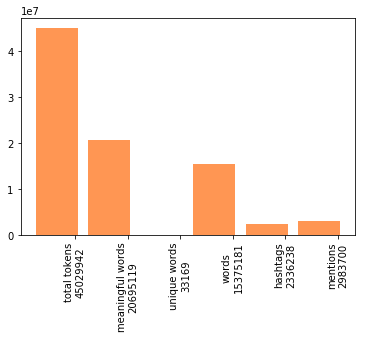

In [190]:
print('SCRAPED TWEETS CORPUS STRUCTURE')
labels, values = zip(*corpus_tweets_scraped)
labelstext = [str(lab)+str('\n')+str(val)+str(val/) for lab,val in corpus_tweets_scraped]
# rearrange your data
labels = np.array(labelstext)
values = np.array(values)
indexes = np.arange(len(labels))
bar_width = 0.35
plt.bar(indexes, values, color='#FF9653')
# add labels
plt.xticks(indexes + bar_width, labels, rotation='vertical')
plt.show()

STREAMED PROFILES TWEETS CORPUS STRUCTURE


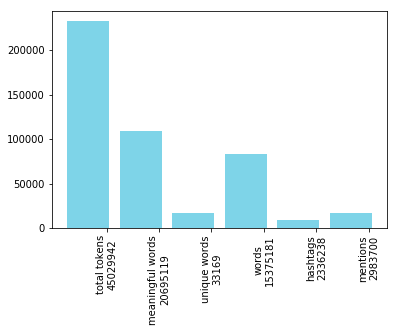

In [191]:
print('STREAMED PROFILES TWEETS CORPUS STRUCTURE')
labels, values = zip(*corpus_tweets_streamed_profile)
labelstext = [str(lab)+str('\n')+str(val) for lab,val in corpus_streamed_profile]
# rearrange your data
labels = np.array(labelstext)
values = np.array(values)
indexes = np.arange(len(labels))
bar_width = 0.35
plt.bar(indexes, values, color='#7ED4E8')
# add labels
plt.xticks(indexes + bar_width, labels, rotation='vertical')
plt.show()

STREAMED KEYWORDS TWEETS CORPUS STRUCTURE


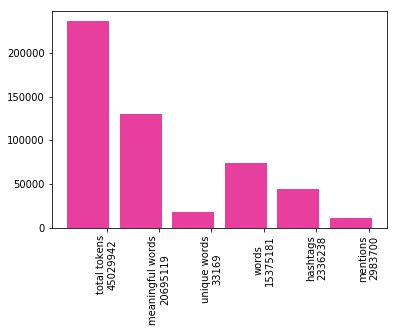

In [192]:
print('STREAMED KEYWORDS TWEETS CORPUS STRUCTURE')
labels, values = zip(*corpus_tweets_streamed_keyword)
labelstext = [str(lab)+str('\n')+str(val) for lab,val in corpus_tweets_streamed_keyword]
# rearrange your data
labels = np.array(labelstext)
values = np.array(values)
indexes = np.arange(len(labels))
bar_width = 0.35
plt.bar(indexes, values, color='#E83F9E')
# add labels
plt.xticks(indexes + bar_width, labels, rotation='vertical')
plt.show()

CORPUSES ADDED UP


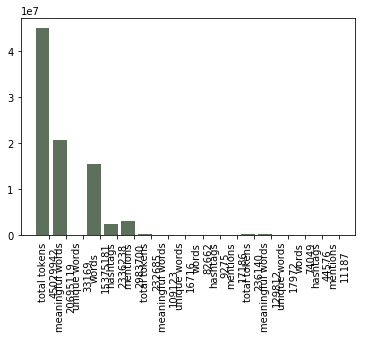

In [197]:
print("CORPUSES ADDED UP")
corpus_all = corpus_tweets_scraped + corpus_tweets_streamed_profile + corpus_tweets_streamed_keyword
labels, values = zip(*corpus_all)
labelstext = [str(lab)+str('\n')+str(val) for lab,val in corpus_all]
# rearrange your data
labels = np.array(labelstext)
values = np.array(values)
indexes = np.arange(len(labels))
bar_width = 0.35
plt.bar(indexes, values, color='#5C705B')
# add labels
plt.xticks(indexes + bar_width, labels, rotation='vertical')
plt.show()

### Wordclouds

Create a wordcloud from the list of tweets created with the above process. Using the [wordcloud library](https://github.com/amueller/word_cloud) by [Andreas Mueller](https://github.com/amueller)

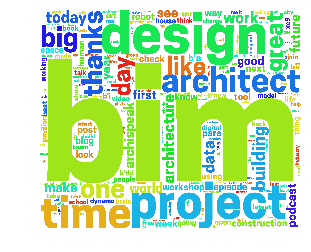

In [142]:
""" 
SCRAPED TWEETS
"""
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# convert list of terms (stream_terms_only) into a string
tweets = ' '.join(words_only_scrape)
# specify fonts, stopwords, background color and other options
wordcloud = WordCloud(font_path='/Users/zoza/Library/Fonts/CooperHewitt-Bold.otf',
                          stopwords=open('Twitter_MINING/twitter-sentiment-analysis-stopwords.txt').read().split(),
                          background_color='white',
                          width=2400,
                          height=2000
                         ).generate(tweets)


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

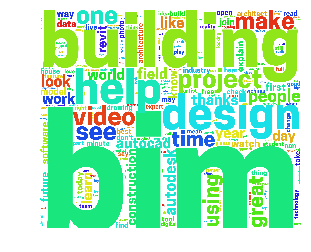

In [144]:
""" 
STREAMED TWEETS, PROFILES
"""
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# convert list of terms (stream_terms_only) into a string
tweets = ' '.join(words_only_sp)
# specify fonts, stopwords, background color and other options
wordcloud = WordCloud(font_path='/Users/zoza/Library/Fonts/CooperHewitt-Bold.otf',
                          stopwords=open('Twitter_MINING/twitter-sentiment-analysis-stopwords.txt').read().split(),
                          background_color='white',
                          width=2400,
                          height=2000
                         ).generate(tweets)


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

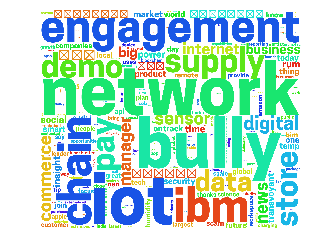

In [145]:
""" 
STREAMED TWEETS, KEYWORDS
"""
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# convert list of terms (stream_terms_only) into a string
tweets = ' '.join(words_only_sk)
# specify fonts, stopwords, background color and other options
wordcloud = WordCloud(font_path='/Users/zoza/Library/Fonts/CooperHewitt-Bold.otf',
                          stopwords=open('Twitter_MINING/twitter-sentiment-analysis-stopwords.txt').read().split(),
                          background_color='white',
                          width=2400,
                          height=2000
                         ).generate(tweets)


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Combined wordcount

Combining the three corpuses, we get these as the most important words: 

In [151]:
words_only_all = words_only_scrape + words_only_sp + words_only_sk
words_only_all_freq = FreqDist(words_only_all)
print(words_only_all_freq.most_common(100))

[('bim', 94749), ('design', 71855), ('time', 49011), ('thanks', 47620), ('big', 45837), ('great', 45457), ('project', 44547), ('one', 42370), ('architecture', 42213), ('like', 41727), ('today', 41242), ('archispeak', 39864), ('see', 37543), ('future', 37355), ('day', 36945), ('data', 35911), ('building', 33209), ('good', 33185), ('work', 33123), ('first', 32630), ('podcast', 32481), ('world', 31631), ('next', 30511), ('check', 30017), ('2017', 29794), ('construction', 28916), ('episode', 28876), ('para', 27575), ('blog', 27569), ('architect', 27282), ('make', 27243), ('week', 26881), ('architects', 26592), ('post', 26327), ("b'a", 25727), ('know', 25587), ('workshop', 25113), ('using', 25058), ('people', 24562), ('life', 24169), ('space', 23051), ('best', 22888), ('2016', 21957), ('digital', 21839), ('pavilion', 21753), ('house', 21572), ('going', 21564), ("b'new", 21296), ('way', 21180), ('dynamo', 21049), ('tools', 20915), ('video', 20199), ('look', 20015), ("b'i", 19682), ('latest',

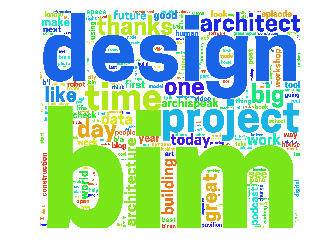

In [152]:
""" 
ALL TWEETS
"""
tweets = ' '.join(words_only_all)
# specify fonts, stopwords, background color and other options
wordcloud = WordCloud(font_path='/Users/zoza/Library/Fonts/CooperHewitt-Bold.otf',
                          stopwords=open('Twitter_MINING/twitter-sentiment-analysis-stopwords.txt').read().split(),
                          background_color='white',
                          width=2400,
                          height=2000
                         ).generate(tweets)


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 2) Term Co-occurence (bigrams, trigrams)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle

In [14]:
def search_coocurrences(searchword, vectorizer):
    coocurrences = []
    for key, value in vectorizer.vocabulary_.items():
        if searchword in key:
            coocurrences.append(key)
    return coocurrences

In [18]:
# SCRAPED TWEETS
ngram_vectorizer = CountVectorizer(ngram_range=(2, 3))  # minimum 2, maximum 3 words
streamed_coocurrences = ngram_vectorizer.fit_transform(words_sp)
streamed_search_list = words_sp_freq.most_common(70) # 20 most common words
with open('co-ocurrences_streamed_profiles.txt', 'wb') as f:
    for i in range(len(streamed_search_list)):
        pickle.dump(search_coocurrences(streamed_search_list[i][0], ngram_vectorizer), f)
        print(search_coocurrences(streamed_search_list[i][0], ngram_vectorizer)[:5]) # first 20 co-occurences

[]
[]
[]
['bim projekt', 'pro bim', 'bim model', 'bim based', 'bim connected']
[]
[]
[]
[]
['design in', 'design tech']
[]
[]
[]
[]
[]
['must see']
['video overloaded']
['2017 41']
[]
['sull innovazione', 'one off', 'drone delivered', 'one meter', 'by drone']
[]
[]
['great hexagonal']
['people driven']
[]
[]
[]
[]
[]
['lantern like', 'genital like', 'escher like', 'campus like', 'like minded']
[]
['real time', 'time lapse', 'inwood times', 'part time']
['lessons learned']
[]
['live works', 'co working']
[]
[]
[]
['hartsfield jackson', 'to field', 'bim to field']
['world famous', 'real world']
[]
[]
['know how']
[]
[]
[]
['first ever']
[]
[]
[]
['must watch']
[]
[]
[]
[]
[]
['data centric', 'meta data', 'data driven', 'data rich', 'data shapes']
[]
[]
[]
[]
[]
[]
['five day', 'the day', 'by the day']
['already rich', 'ready to', 'ready to use']
['fact checked']
[]
[]
['self builders', 'self build']
[]
['free standing']



## 3) Keywords extraction

Extracting keywords from the list of tweets created with the above process.

First, tested a [Python implementation of the Rapid Automatic Keyword Extraction (RAKE) algorithm] (https://github.com/zelandiya/RAKE-tutorial)

In [ ]:
import Twitter_MINING.RAKEtutorial.rake as rk
import operator
rake_object = rk.Rake('Twitter_MINING/twitter-sentiment-analysis-stopwords.txt', 4, 3, 5) # words of minimum length 4, in groups of maximum 2, occurring at least 3 times in the text; this happens to give the best results with the particular corpus

In [ ]:
### SCRAPED TWEETS
# remove "float" objects: convert them to strings
tweets_scrape = ''
for item in tweets_l_scrape:
    try: 
        tweets_scrape += item
    except TypeError:
        tweets_scrape = tweets_scrape
# extract keywords
keywords_scraped = rake_object.run(tweets_scrape)
print(keywords_scraped[:30])

In [ ]:
### STREAMED TWEETS, PROFILES
# remove "float" objects: skip
tweets_stream_profiles = ''
for item in tweets_l_stream_profiles:
    try:
        tweets_stream_profiles += item
    except TypeError:
        tweets_stream_profiles = tweets_stream_profiles
# extract keywords
keywords_streamed_profiles = rake_object.run(tweets_stream_profiles)
print(keywords_streamed_profiles[:30])

[('españa #opinión #bimonyourside', 18.57099292293467), ('escuela politécnica superior', 15.6), ('photographer aurélien villette', 14.916666666666666), ('cataluña son favorables', 14.20563909774436), ('tecnología #bim transformará', 12.62938613111027), ('stéphane côté', 11.93985260770975), ('cataluña implantará', 10.148496240601503), ('españa prevé', 9.4496336996337), ('un vídeo', 9.273488865323436), ('tres años', 9.244505494505495), ('españa y', 9.175949489107385), ('cheese sandwich modeled', 9.0), ('/gr4qzza2ix #wib #wia…', 9.0), ('@portofrotterdam @ramlabnl aim', 9.0), ('roaring tide productions', 9.0), ('simulating watercolor paints', 9.0), ('staircase crush @gemeentemuseum', 9.0), ('reserveer deze datum', 9.0), ('@eraikunecluster interesantes avances', 9.0), ('sleeping bags required', 9.0), ('/xlgbmdqrjv @mcavoygroup @hadeelsafaa…', 9.0), ('f1 champ @lewishamilton', 9.0), ('veauthier meyer architekten', 9.0), ('#iluminación @icandela_com', 8.99635922330097), ('aprende cómo', 8.960884353741497), ('las ediciones anteriores', 8.921052631578947), ('audio cassette tape', 8.86111111111111), ('un referente internac…', 8.75609756097561), ('un precio especial', 8.75609756097561)]

In [ ]:
### STREAMED TWEETS, KEYWORDS
# remove "float" objects: skip
tweets_stream_keywords = ''
for item in tweets_l_stream_keywords:
    try:
        tweets_stream_keywords += item
    except TypeError:
        tweets_stream_keywords = tweets_stream_keywords
# extract keywords
keywords_streamed_keywords = rake_object.run(tweets_stream_keywords)
print(keywords_streamed_keywords[:20])

[('タックスヘイブンの単語を見るたびに心の中のtm networkが何かを歌い出しそうになるのにパラダイス文書だなんて心の中の光genjiがrt @dollyray1987', 17.830082592845752), ('nécessaire #tranfonum', 9.418604651162791), ('satılıyor', 9.164835164835164), ('rigged dem primary', 9.0), ('cosa ci insegna', 9.0), ('sullivan commends hilscher', 9.0), ('#watson supply chain', 8.958414465816356), ('promoted several times', 8.942857142857143), ('/cbj0kz8z94 #artificialintelligence #internetofthing…', 8.879487179487178), ('french resort town', 8.855614973262032), ('imag㏌ed yet', 8.846153846153847), ('maar een middel', 8.833333333333334), ('tony romo made', 8.794595887135342), ('beta testing beats', 8.789473684210526), ('écosystème #startup', 8.785529715762273), ('reports falling profit', 8.75), ('wales prize winner', 8.744736842105263), ('complex made simple', 8.743796207007392), ('marshawn lynch keeping', 8.690476190476192), ('digme fitness richmond', 8.631578947368421), ('rm education plc', 8.625), ('tax havens #4corners', 8.607107107107108), ('niet het doel', 8.555555555555555), ('proposed pipelines may', 8.458333333333334), ('insurance pool contributions', 8.45021645021645), ('industrialized digital pl…', 8.395121951219512), ('telecom companies charging', 8.395043541512774), ('#leonardolive w/ @dhinchcliffe', 8.39360754985755), ('/cdvhxbkjk4 #artificialintelligence #internetofthings…', 8.38890854907804), ('computer science related', 8.363636363636363)]

Results are not that convincing and do not reflect the word frequency represented before. Also, they depend a lot on the parameters with which Rake is called (word length, word group size, occurrence). Below are the best results:

### Keyword Extraction: Parser

Another small script: [keyword_extraction_w_parser](https://github.com/naushadzaman/keyword-extraction-from-tweets) (made for twitter specifically) provides a very flexible way to extract keywords, and works relatively well with the entire collection of tweets converted into a single string (as explained in: Preprocessing the text of tweets). For this purpose, I modified the string to include #hashtags and @mentions.

In [ ]:
import Twitter_MINING.keyword_extraction_w_parser as kep
keywords_2_scraped=kep.get_keywords(tweets_scrape)
print(keywords_2_scraped[0])

### Comparing Hashtags to Keywords

An efficient approach is to rely on #hashtags as keywords users themselves have identified.

The list of unique hashtags was obtained from the same collection of tweets used above. In a total of 18473 tweets, there are 12785 hashtags, less than a quarter of them unique - 3607 words. The three different sets of hashtags - 1) all tweets from 8 profiles, 2) tweets captured in streaming tweets from selected profiles (number?) and 3) tweets captured in streaming keywords are compared. Below is a list of #hashtags which appear in all three sets: 

In [ ]:
# load lists with wordfrequency, hashtags, keywords
with open('..pathto/wordfrequency_stream_profiles.txt', 'rb') as f:
    wordfrequencylist=pickle.load(f)
with open('..pathto/hashtag_stream_profiles.txt', 'rb') as f:
    hashtaglist=pickle.load(f)
#remove hashtags:
hashtaglistw = []
for item in hashtaglist:
    hashtaglistw.append((item[0][1:],item[1]))

In [ ]:
# intersect the two lists (lists are tuples of words and their frequency, we need the first value only)
commonwords=set(list(zip(*wordfrequencylist))[0]).intersection(list(zip(*hashtaglistw))[0])
frequentcommonwords=set(list(zip(*wordfrequencylist[:200]))[0]).intersection(list(zip(*hashtaglistw[:200]))[0])

the last list comprises only 18 words that are commonly found in the first 200 entries of both lists. These words are:

<code>[architects', 'architecture', 'autocad', 'autodesk', 'bim', 'building', 'concrete', 'construction', 'data', 'design', 'digital', 'engineering', 'future', 'housing', 'passivhaus', 'revit', 'tech', 'technology']</code>

## 3) Term Co-Occurences

## 4) Sentiment Analysis

In [ ]:
# positive and negative terms
positive_vocab = [
    'good', 'nice', 'great', 'awesome', 'outstanding',
    'fantastic', 'terrific', ':)', ':-)', 'like', 'love',
    # shall we also include game-specific terms?
    # 'triumph', 'triumphal', 'triumphant', 'victory', etc.
]
negative_vocab = [
    'bad', 'terrible', 'crap', 'useless', 'hate', ':(', ':-(',
    # 'defeat', etc.
]

# compute probabilities
p_t = {}
p_t_com = defaultdict(lambda : defaultdict(int))
com = defaultdict(lambda : defaultdict(int))
sp_wordfreq = FreqDist(words_sp)

for i in range(len(words_sp)-1):
    for j in range(i+1, len(words_sp)):
        w1, w2 = sorted([words_sp[i], words_sp[j]])
        if w1 != w2:
            com[w1][w2] += 1
                
for term, n in sp_wordfreq.items():
    p_t[term] = n / len(tweets_l_stream_profiles)
    for t2 in com[term]:
        p_t_com[term][t2] = com[term][t2] / len(tweets_l_stream_profiles)
print(com)
pmi = defaultdict(lambda : defaultdict(int))
for t1 in p_t:
    for t2 in com[t1]:
        denom = p_t[t1] * p_t[t2]
        pmi[t1][t2] = math.log2(p_t_com[t1][t2] / denom)
#print(pmi)
''' 
semantic_orientation = {}
for term, n in p_t.items():
    positive_assoc = sum(pmi[term][tx] for tx in positive_vocab)
    negative_assoc = sum(pmi[term][tx] for tx in negative_vocab)
    semantic_orientation[term] = positive_assoc - negative_assoc
    
semantic_sorted = sorted(semantic_orientation.items(), 
                         key=operator.itemgetter(1), 
                         reverse=True)
top_pos = semantic_sorted[:10]
top_neg = semantic_sorted[-10:]
print(top_pos, top_neg)
'''

## 5) Further analysis (images etc.)

The tweets contain much more information than simply the text of the tweet. For example, it is possible to extract the attached media (see bellow: [Extracting images (media)](extractingimages)) or geolocation from the collected tweets.

### <a name="extractingimages"></a>Extracting images (media) from collected tweets

In [ ]:
import urllib
import pandas as pd

df=pd.read_json('profile_tweets.json', lines=True)

for label, value in df.entities.iteritems(): # iterate through the dictionary of entities
  if type(value)==dict and 'media' in value.keys(): # some value.keys are nan, and their type is 'float'
    for thing in value['media']:
      urllib.urlretrieve(thing['media_url'],'%s.jpg' %label) # save all images with the unique of their index in the df

###EXTRAS

Check json file for errors:

In [ ]:
def parse():
  files = [f for f in listdir('.') if f.endswith('.json') and isfile(join('.', f))]
  for afile in files:
    with open(afile) as json_file:
      try:
        json.load(json_file)
        read_json_files.append(afile)
      except ValueError, e:
        print ("JSON object issue: %s") % e
        invalid_json_files.append(afile)
  print invalid_json_files, len(read_json_files)